# Alignment

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from glob import glob
import re
import yaml
import sys
from pathlib import Path
import ompy as om
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append("./lib/turbo.py")
sys.path.append("./kshell")
from shellanalyzer import Analyzer

In [7]:
fig_width_pt = 233.1  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = np.array([fig_width,fig_height])
fig_path = Path("figures")

plt.rc('text', usetex=True)

def savefig(fig, path, transparent=True, dpi=196):
    fig.savefig(fig_path / path, dpi=dpi, transparent=transparent, bbox_inches='tight') 

In [8]:
%matplotlib notebook

In [4]:
parameters = yaml.safe_load(open("zn70.yaml"))
ignore = parameters["channels to ignore"]

# OSCAR

In [41]:
def loadoscar(calibrated=True):
    pattern = ".*eg_chn(\d+).bin"
    if calibrated:
        fnames = glob("eg_chn*.bin")
    else:
        fnames = glob("uncalib/eg_chn*.bin")
    channels = [int(re.match(pattern, fname)[1]) for fname in fnames]
    channels, fnames = zip(*sorted(zip(channels, fnames)))
    raw = [np.fromfile(fname, dtype='float32') for fname in fnames]
    if calibrated:
        bins = np.linspace(0, 12000, 5000)
    else:
        bins = np.linspace(0, 3000, 5000)
    data = [np.histogram(r, bins=bins)[0] for r in raw]
    good_data = [datum for channel, datum  in zip(channels, data)
                if channel not in ignore]
    good_channels = [channel for channel in channels if channel not in ignore]
    good_data = np.vstack(good_data)
    return good_data, bins, good_channels

In [42]:
oscar_calib, bins_c, good_channels = loadoscar(True)
oscar_ucalib, bins_u, _ = loadoscar(False)

<IPython.core.display.Javascript object>


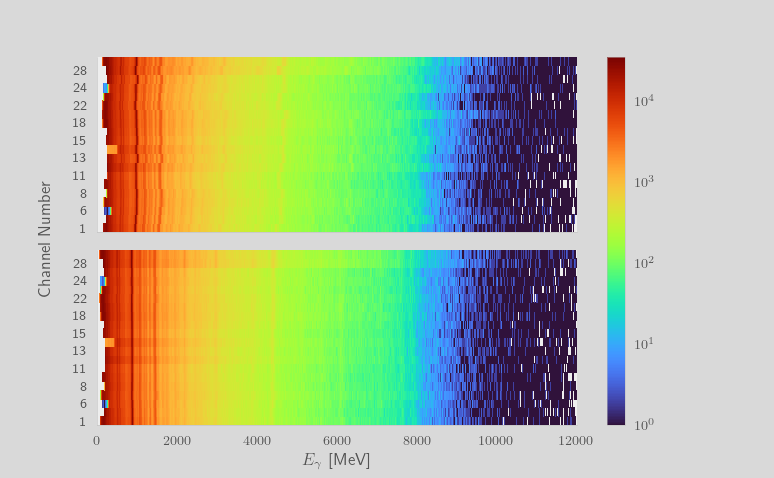

In [45]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(nrows=2, sharey=True, figsize=2*fig_size)
    mesh = ax[0].pcolormesh(bins_u, range(len(good_channels)+1), oscar_ucalib, norm=LogNorm(),
                 cmap='turbo', rasterized=True)
    mesh = ax[1].pcolormesh(bins_c, range(len(good_channels)+1), oscar_calib, norm=LogNorm(),
                 cmap='turbo', rasterized=True)
    ax[0].set_yticks(np.arange(0.5, len(good_channels), 2))
    ax[0].set_yticklabels(good_channels[::2])
    ax[0].set_xticks([])
    ax[1].set_xlabel(r"$E_{\gamma}$ [MeV]")
    fig.text(0.05, 0.5, 'Channel Number', va='center', rotation='vertical')
    fig.subplots_adjust(hspace=0.1)
    fig.colorbar(mesh, ax=ax.ravel().tolist())
    savefig(fig, "eg.pdf")

## Fit residual

In [32]:
from sklearn.linear_model import LinearRegression

In [65]:
data = np.loadtxt("gamma_peaks_si.csv", delimiter=',')

<IPython.core.display.Javascript object>


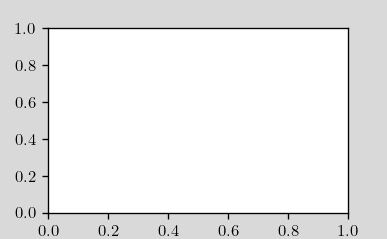

In [72]:
Eg = data[:, 0]
peaks = data[:, 0:].T
with plt.style.context("rapport"):
    fig, ax = plt.subplots()
    cmap = plt.cm.Blues(np.linspace(0, 1, len(good_channels)+1))
    i = 0
    for detector in peaks:
        X = detector.reshape(-1, 1)
        reg = LinearRegression().fit(X, Eg)
        if reg.score(X, Eg) <= 0:
            continue
        y_hat = reg.predict(X)
        res = Eg - y_hat
        ax.plot(Eg, res, "-o", color=cmap[i], ms=2)
        i+= 1
    ax.set_xlabel(r"$E_\gamma$ [MeV]")
    ax.set_ylabel("Residual")
    savefig(fig, "eg_residuals.pdf")

# SiRi

In [104]:
def loadmat(b, f):
    raw = np.fromfile(f"edeb{b}f{f}.bin", dtype="uint32").reshape(-1, 2).astype("float32")
    raw += np.random.random(raw.shape)
    hist, Y, X = np.histogram2d(raw[:, 0], raw[:, 1], bins=1000)
    return hist.T, X, Y

In [105]:
b1f1, X1, Y1 = loadmat(1, 1)
b8f1, X2, Y2 = loadmat(8, 1)

<IPython.core.display.Javascript object>


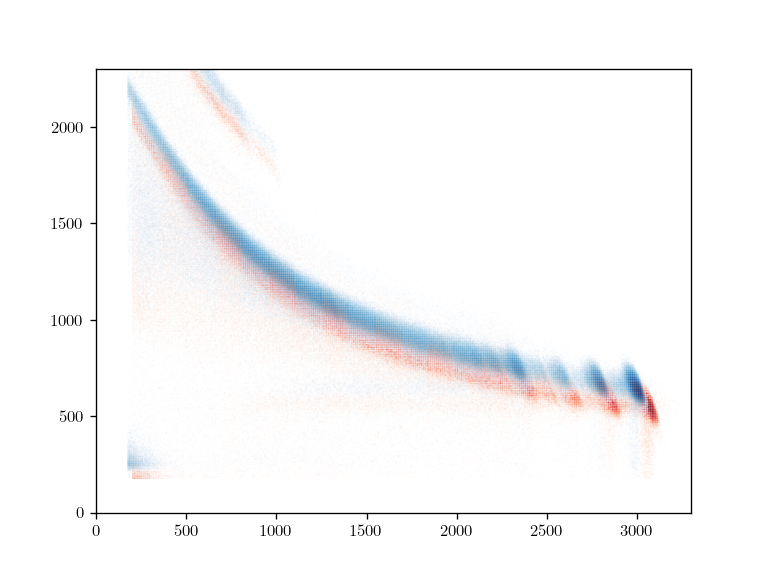

(0.0, 3300.0)

In [111]:
fig, ax = plt.subplots()
ax.pcolormesh(X1, Y1, b1f1, norm=LogNorm(), cmap='Reds', alpha=0.2)
ax.pcolormesh(X2, Y2, b8f1, norm=LogNorm(), cmap='Blues', alpha=0.2)
ax.set_ylim(0, 2300)
ax.set_xlim(0, 3300)

In [135]:
raw = np.fromfile(f"edeb8f1.bin", dtype="uint32").reshape(-1, 2).astype("float32")
raw += np.random.random(raw.shape)
Eg = 1.0196*raw[:, 1] - 31.62
Ex = 1.00911*raw[:, 0] - 83.825
hist, X, Y = np.histogram2d(Eg, Ex, bins=1000)

<IPython.core.display.Javascript object>


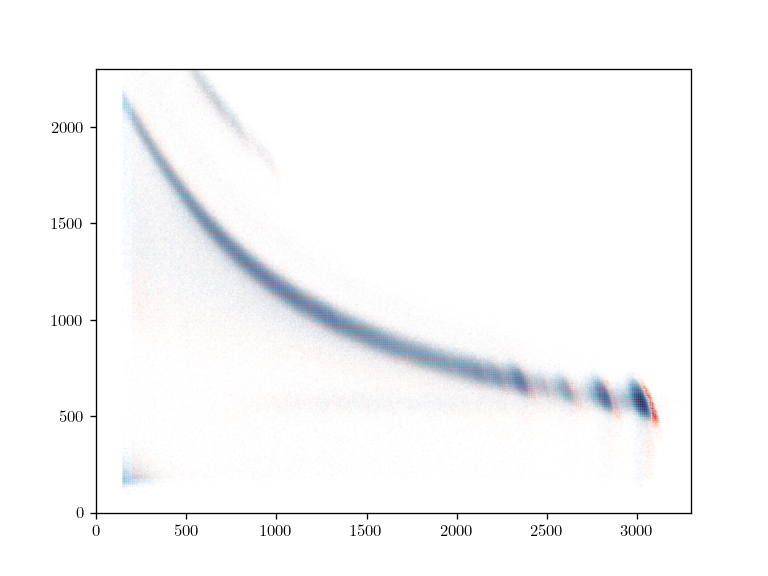

(0.0, 3300.0)

In [136]:
fig, ax = plt.subplots()
ax.pcolormesh(X1, Y1, b1f1, norm=LogNorm(), cmap='Reds', alpha=0.2)
ax.pcolormesh(X, Y, hist, norm=LogNorm(), cmap='Blues', alpha=0.2)
ax.set_ylim(0, 2300)
ax.set_xlim(0, 3300)

# Time

In [32]:
def loadtime(calib=True, bins=None):
    if calib:
        fnames = glob("t_chn*.bin")
    else:
        fnames = glob("uncalib/t_chn*.bin")
        
    pattern = ".*t_chn(\d+).bin"
    channels = [int(re.match(pattern, fname)[1]) for fname in fnames]
    channels, fnames = zip(*sorted(zip(channels, fnames)))
    raw = [np.fromfile(fname, dtype='float32') for fname in fnames]
    if bins is None:
        bins = np.histogram(raw[0], bins=1000)[1]
    data = [np.histogram(r, bins=bins)[0] for r in raw]
    
    good_data = [datum for channel, datum  in zip(channels, data)
                if channel not in ignore]
    good_channels = [channel for channel in channels if channel not in ignore]
    return bins, np.vstack(good_data), good_channels

In [33]:
bins, t_ucalib, good_channels = loadtime(False)
bins_calib, t_calib, _ = loadtime(True)

<IPython.core.display.Javascript object>


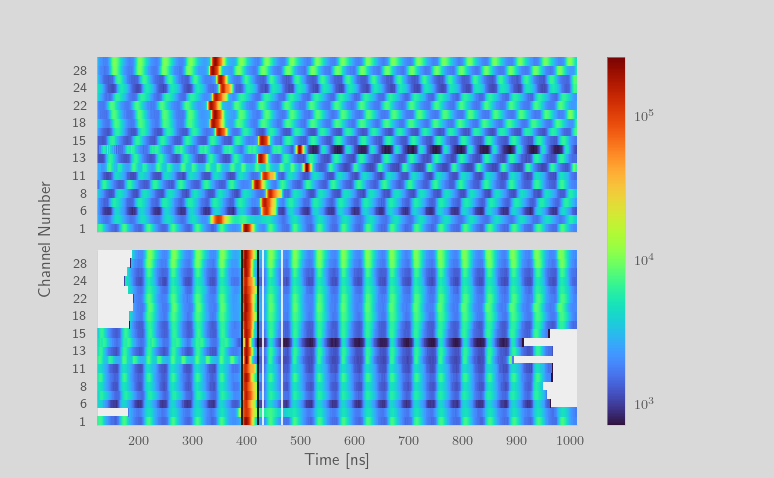

In [34]:
with plt.style.context("rapport"):
    fig, (ax_u, ax_c ) = plt.subplots(nrows=2, sharey=True, figsize=2*np.array(fig_size))
    vmin, vmax = np.min(t_ucalib), np.max(t_ucalib)
    mesh = ax_u.pcolormesh(bins, range(len(good_channels)+1), t_ucalib, norm=LogNorm(),
                 cmap='turbo', rasterized=True)
    _ = ax_c.pcolormesh(bins_calib, range(len(good_channels)+1), t_calib, norm=LogNorm(),
                 cmap='turbo', vmin=vmin, vmax=vmax, rasterized=True)
    ax_u.set_yticks(np.arange(0.5, len(good_channels), 2))
    ax_u.set_yticklabels(good_channels[::2])
    ax_u.set_xticks([])
    #ax.set_xlabel(r"$E_{\gamma}$ [MeV]")
    ax_c.set_xlabel(r"Time [ns]")
    ax_c.axvline(x=parameters['gates']['prompt'][0], c='k')
    ax_c.axvline(x=parameters['gates']['prompt'][1], c='k')
    ax_c.axvline(x=parameters['gates']['background'][0], c='white')
    ax_c.axvline(x=parameters['gates']['background'][1], c='white')
    fig.text(0.05, 0.5, 'Channel Number', va='center', rotation='vertical')
    fig.subplots_adjust(hspace=0.1)
    fig.colorbar(mesh, ax=np.array([ax_u, ax_c]).ravel().tolist())
    savefig(fig, "time.pdf")

# Matrix

In [28]:
fg = np.fromfile("egex_fg.bin", dtype="float32").reshape((-1, 2))
bg = np.fromfile("egex_bg.bin", dtype="float32").reshape((-1, 2))
nbins = 1000
bins = np.linspace(0, 12000, nbins)
hfg, *_ = np.histogram2d(fg[:, 0], fg[:, 1], bins=bins)
hbg, *_ = np.histogram2d(bg[:, 0], bg[:, 1], bins=bins)
del fg, bg
mat = hfg - hbg
mid = bins + (bins[1]-bins[0])/2
mid = mid[:-1]
raw = om.Matrix(values=mat.T, Eg=mid, Ex=mid)

<IPython.core.display.Javascript object>


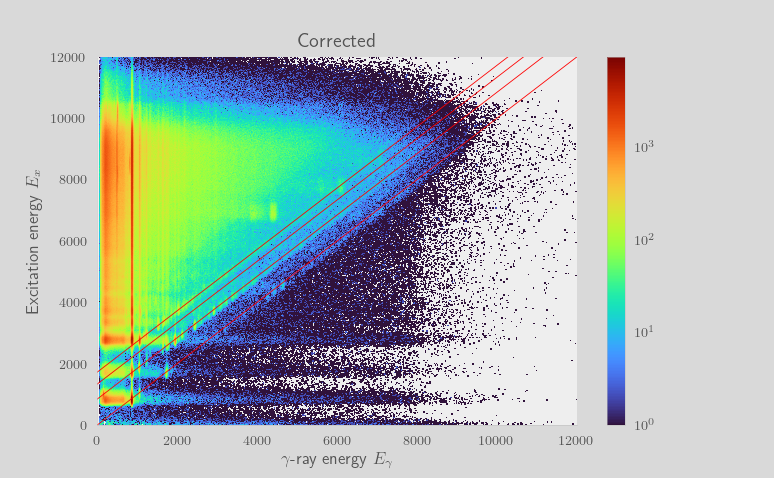

In [29]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(figsize=2*np.array(fig_size))
    raw.plot(ax=ax, cmap='turbo', title='Corrected', rasterized=True)
    raw.plot_diagonal(ax=ax, point=(1081, 1080))#, vmin=1e0, vmax=1e2)
    raw.plot_diagonal(ax=ax, point=(1076, 1877+43.5))
    raw.plot_diagonal(ax=ax, point=(1084, 2763+43.5))
    raw.plot_diagonal(ax=ax, point=(1973, 3263+43.5))
    savefig(ax.figure, "egex_corr.pdf")

In [30]:
fg = np.fromfile("calib_not_ex/egex_fg.bin", dtype="float32").reshape((-1, 2))
bg = np.fromfile("calib_not_ex/egex_bg.bin", dtype="float32").reshape((-1, 2))
nbins = 1000
bins = np.linspace(0, 12000, nbins)
hfg, *_ = np.histogram2d(fg[:, 0], fg[:, 1], bins=bins)
hbg, *_ = np.histogram2d(bg[:, 0], bg[:, 1], bins=bins)
del fg, bg
mat = hfg - hbg
mid = bins + (bins[1]-bins[0])/2
mid = mid[:-1]
raw = om.Matrix(values=mat.T, Eg=mid, Ex=mid)

<IPython.core.display.Javascript object>


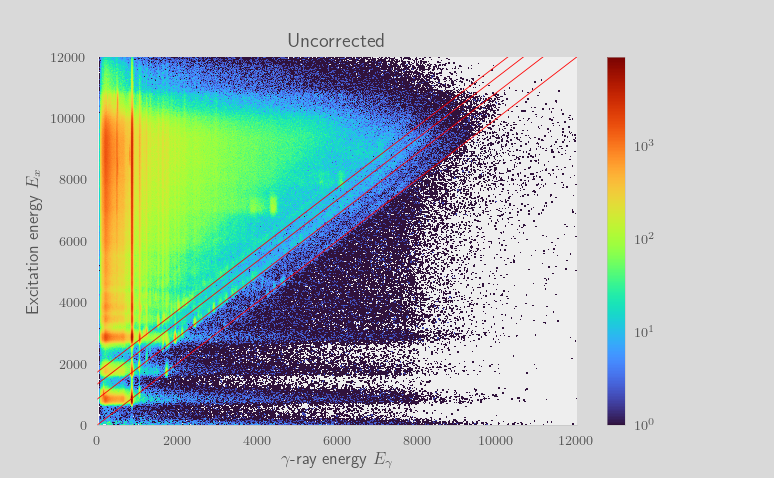

In [31]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(figsize=2*np.array(fig_size))
    raw.plot(ax=ax, cmap='turbo', title='Uncorrected', edgecolors=None, rasterized=True)
    ax.grid(False)
    raw.plot_diagonal(ax=ax, point=(1081, 1080))#, vmin=1e0, vmax=1e2)
    #raw.plot_diagonal(ax=ax, point=(890, 837.8))
    #raw.plot_diagonal(ax=ax, point=(892, 1711))
    raw.plot_diagonal(ax=ax, point=(1076, 1877+43.5))
    raw.plot_diagonal(ax=ax, point=(1084, 2763+43.5))
    raw.plot_diagonal(ax=ax, point=(1973, 3263+43.5))
    ax.grid(False)
    savefig(ax.figure, "egex_uncorr.pdf", transparent=True)

# Oslo Method

## Unfolding

In [27]:
unfolded = om.Matrix(path="unfolded.npy")
unfolded = unfolded.loc[:10000, :]

<IPython.core.display.Javascript object>


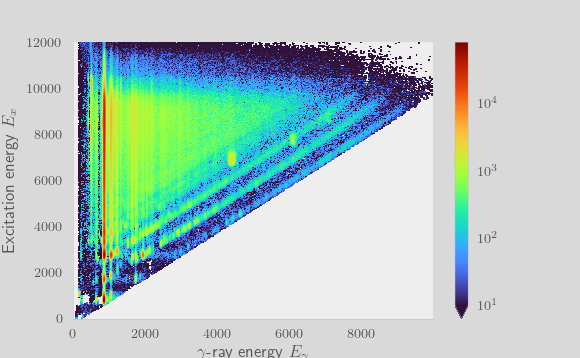

In [28]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(figsize=1.5*fig_size)
    _, _, _ = unfolded.plot(ax=ax, vmin=1e1, rasterized=True)
    savefig(ax.figure, "unfolded.pdf", dpi=300)

In [29]:
contaminants = unfolded.loc[4000:8000, 6500:10000]

## Response

In [41]:
fg = np.fromfile("sorting/data/egex_fg.bin", dtype="float32").reshape((-1, 2))
bg = np.fromfile("sorting/data/egex_bg.bin", dtype="float32").reshape((-1, 2))
nbins = 1000
bins = np.linspace(0, 12000, nbins)
hfg, *_ = np.histogram2d(fg[:, 0], fg[:, 1], bins=bins)
hbg, *_ = np.histogram2d(bg[:, 0], bg[:, 1], bins=bins)
del fg, bg
mat = hfg - hbg
mid = bins + (bins[1]-bins[0])/2
mid = mid[:-1]
raw = om.Matrix(values=mat.T, Eg=mid, Ex=mid)

<IPython.core.display.Javascript object>


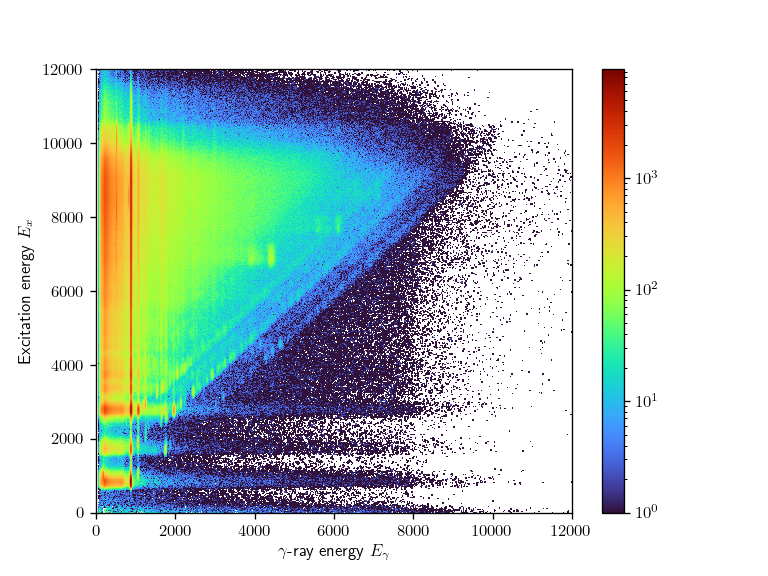

(<matplotlib.collections.QuadMesh at 0x7fac2c444b80>,
 <Figure size 640x480 with 2 Axes>)

In [42]:
raw.plot()

<IPython.core.display.Javascript object>


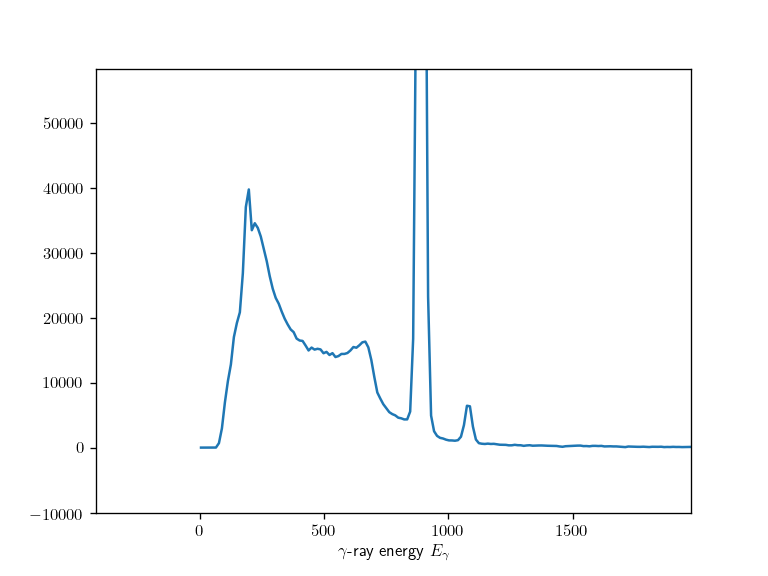

In [92]:
raw.plot_projection(axis='Eg', Emin=600, Emax=1250, marker=None)

In [44]:
folderpath = "matrices/oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

<IPython.core.display.Javascript object>


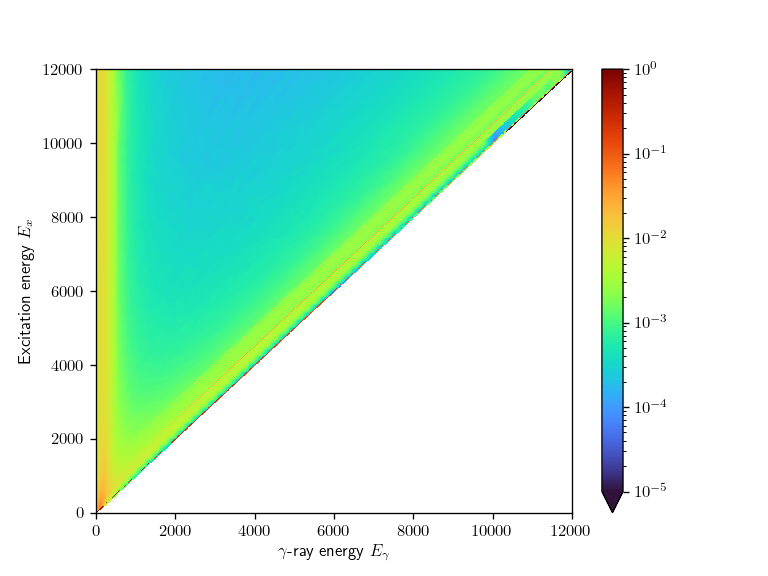

(<matplotlib.collections.QuadMesh at 0x7fac2c42b310>,
 <Figure size 640x480 with 2 Axes>)

In [45]:
R_ompy_unf.plot(scale='log', vmin=1e-5)

In [46]:
stripe = R_ompy_unf.loc[:6000, 4000]
stripe = om.Vector(E=stripe.Eg, values=stripe.values)

In [49]:
R_ompy_unf.shape

(999, 999)

<IPython.core.display.Javascript object>


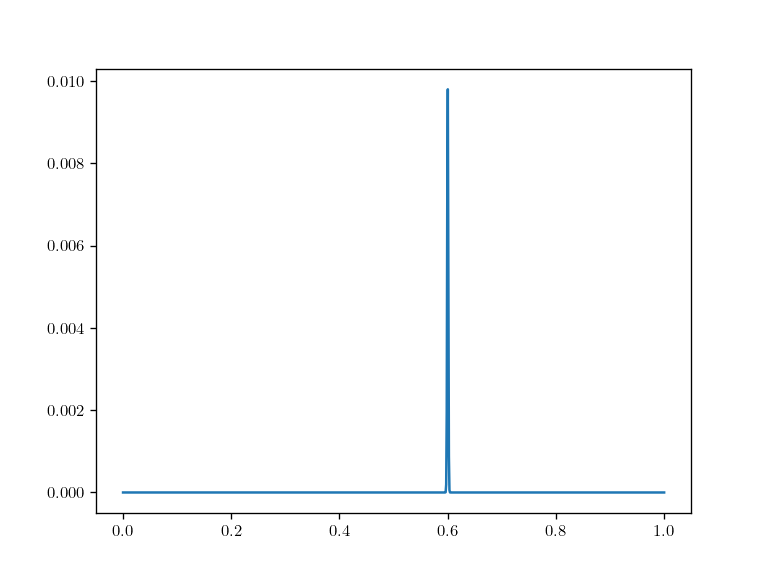

In [90]:
X = np.linspace(0, 1, 999)
fig, ax = plt.subplots()
Y = 0.01*np.exp(-0.5*((X-0.6)/0.001)**2)
gaus = om.Vector(Y, X)
plt.plot(X, Y)

<IPython.core.display.Javascript object>


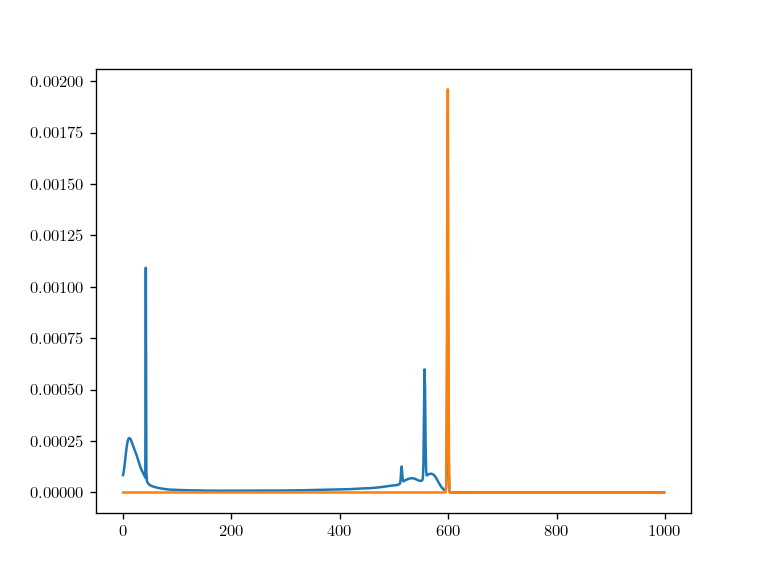

In [101]:
Z = R_ompy_unf.values.T @Y
Z.shape
fig, ax = plt.subplots()
ax.plot(Z)
ax.plot(0.2*Y)
#ax.set_yscale('log')
#ax.set_ylim([1e-5, 1e-2])

<IPython.core.display.Javascript object>


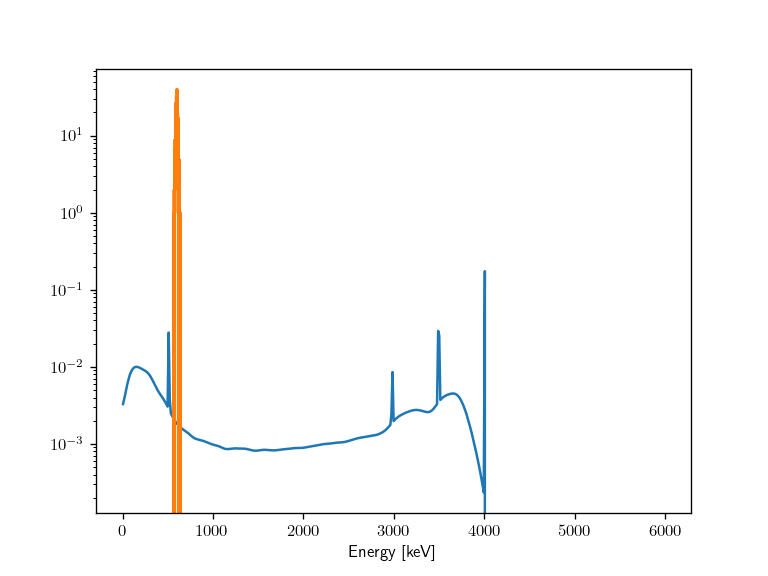

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac2ca84f10>)

In [47]:
stripe.plot(marker=None, scale='log')

## Remove carbon and oxygen

In [6]:
corrected = om.Matrix(path="retouched.npy")

<IPython.core.display.Javascript object>


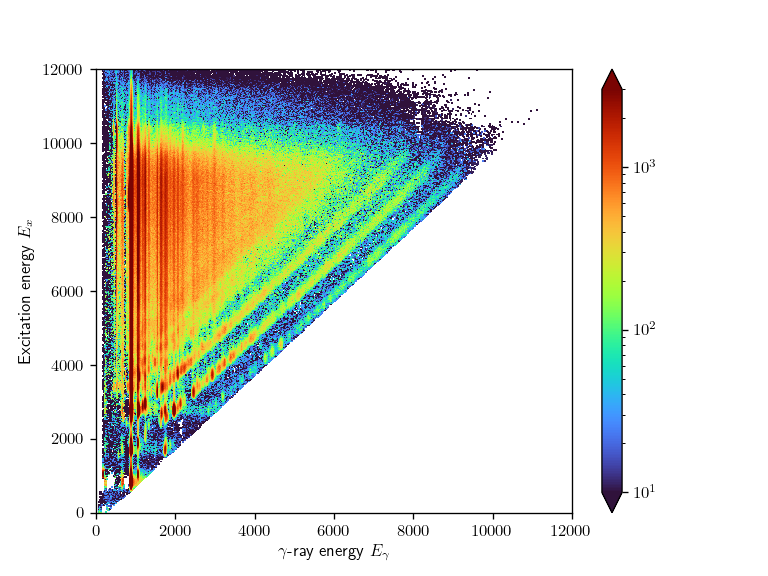

(<matplotlib.collections.QuadMesh at 0x7fd0e7e98040>,
 <Figure size 640x480 with 2 Axes>)

In [26]:
corrected.plot(vmin=1e1, vmax=3e3)

In [28]:
contaminants_corr = corrected.loc[4000:8000, 6500:10000]

<IPython.core.display.Javascript object>


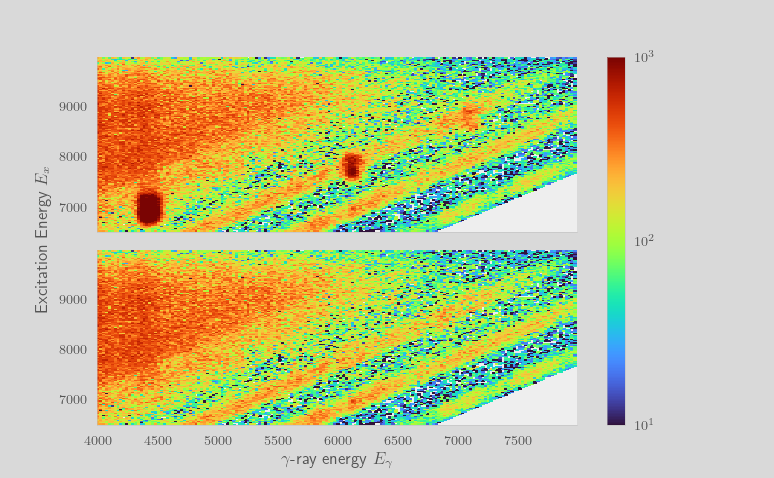

In [40]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=2*fig_size)
    mesh, _, _ = contaminants.plot(ax=ax[0], vmin=1e1, vmax=1e3, add_cbar=False)
    contaminants_corr.plot(ax=ax[1], vmin=1e1, vmax=1e3, add_cbar=False)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[1].set_ylabel("")
    fig.text(0.05, 0.5, r'Excitation Energy $E_{x}$', va='center', rotation='vertical')
    fig.subplots_adjust(hspace=0.1)
    fig.colorbar(mesh, ax=ax.ravel().tolist())
    savefig(fig, "egex.pdf")

## First Generation

In [7]:
fg = om.Matrix(path="firstgen.npy")
fg_u = om.Matrix(path="firstgen_untouched.npy")

<IPython.core.display.Javascript object>


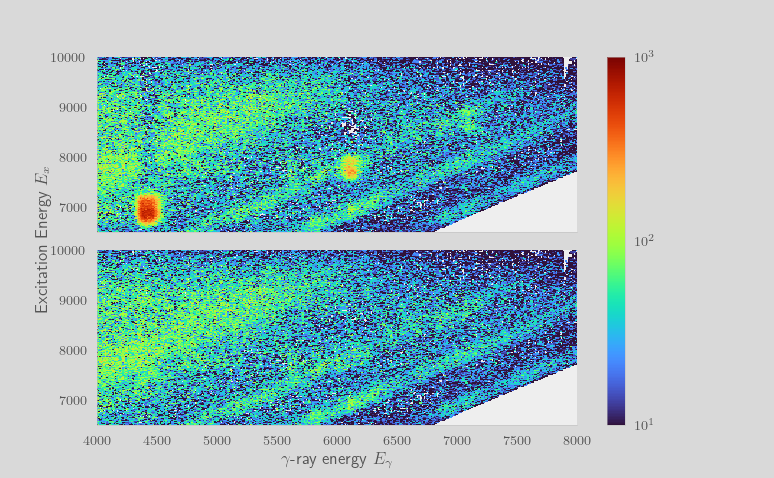

In [26]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=2*fig_size)
    mesh, _, _ = fg_u.plot(ax=ax[0], vmin=1e1, vmax=1e3, add_cbar=False, rasterized=True)
    fg.plot(ax=ax[1], vmin=1e1, vmax=1e3, add_cbar=False, rasterized=True)
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")
    ax[1].set_ylabel("")
    ax[0].set_xlim([4000, 8000])
    ax[0].set_ylim([6500, 10000])
    fig.text(0.05, 0.5, r'Excitation Energy $E_{x}$', va='center', rotation='vertical')
    fig.subplots_adjust(hspace=0.1)
    fig.colorbar(mesh, ax=ax.ravel().tolist())
    savefig(fig, "firstgen_compare.pdf", dpi=300)

<IPython.core.display.Javascript object>


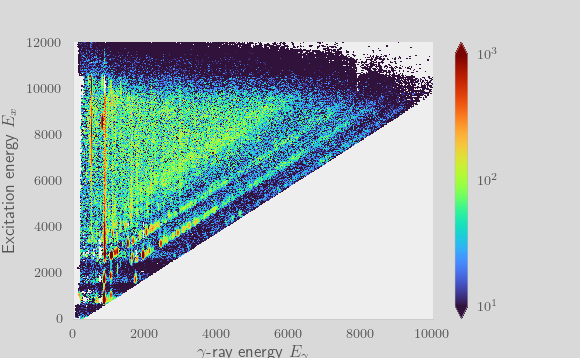

In [25]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(figsize=1.5*fig_size)
    _, _, _ = fg.plot(ax=ax, vmin=1e1, vmax=1e3, rasterized=True)
    ax.set_xlim([0, 10000])
    savefig(ax.figure, "firstgen.pdf", dpi=300)

# Ensemble 

In [40]:
#ensemble = om.LazyEnsemble(path="./saved_run/normalizers")
ensemble = om.Ensemble(path="./saved_run/normalizers")
ensemble.load()
ensemble.rebin(120.0)
print("Bin width: ", ensemble.firstgen.Ex[1] - ensemble.firstgen.Ex[0])


Bin width:  120.0


<IPython.core.display.Javascript object>


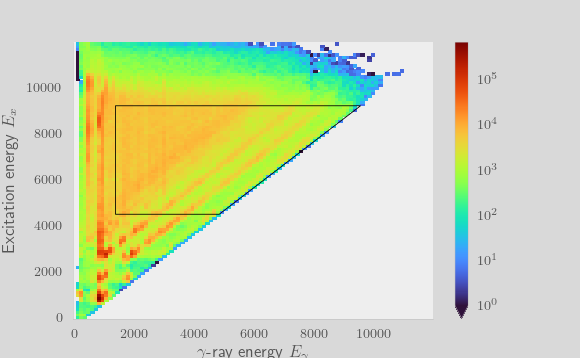

In [43]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(figsize=1.5*fig_size)
    ensemble.firstgen.plot(ax=ax, vmin=1, rasterized=True)
    om.Cut(ensemble.firstgen, Ex_min=4475, Ex_max=9187,
           Eg_min=1375, Eg_max=9187+300).plot(ax, color='k')
    #ax.set_xlabel(r"$\gamma$-ray energy $E_\gamma$ [keV]")
    #ax.set_ylabel(r"Excitation energy $E_x$ [keV]")

    savefig(ax.figure, "trapezoid.pdf", dpi=300)

# Extraction

In [46]:
mat = ensemble.get_firstgen(0).copy()
mat_u = om.Matrix(path="matrices/firstgen_untouched.npy").rebin('Eg', binwidth=120, inplace=False).rebin('Ex', binwidth=120, inplace=False)
std = ensemble.std_firstgen_norm.copy()

cut = om.Action().trapezoid(Ex_min=4475, Ex_max=9186, Eg_min=1375, Eg_max=9187+300)
extractor = om.Extractor(ensemble=ensemble)#options={'maxfev': 10, 'maxiter': 10, 'disp': True})
#extractor.method = 'Nelder-Mead'
extractor.trapezoid = cut

cut.act_on(mat)
cut.act_on(std)
cut.act_on(mat_u)
_, _, product = extractor.decompose(mat, std, product=True)
_, _, product_u = extractor.decompose(mat_u, std, product=True)



In [54]:
std = extractor.get_product_std(Ex=mat.Ex)

<IPython.core.display.Javascript object>


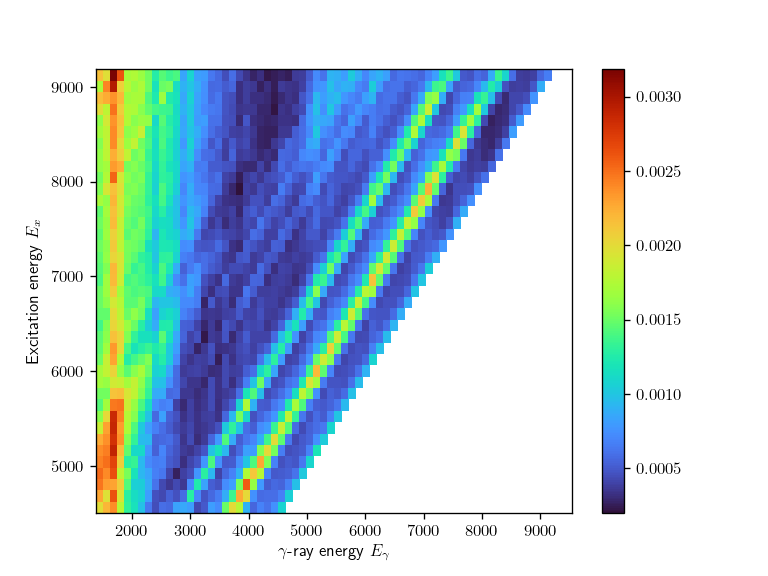

(<matplotlib.collections.QuadMesh at 0x7f3f9c7147c0>,
 <Figure size 640x480 with 2 Axes>)

In [55]:
std.plot()

<IPython.core.display.Javascript object>


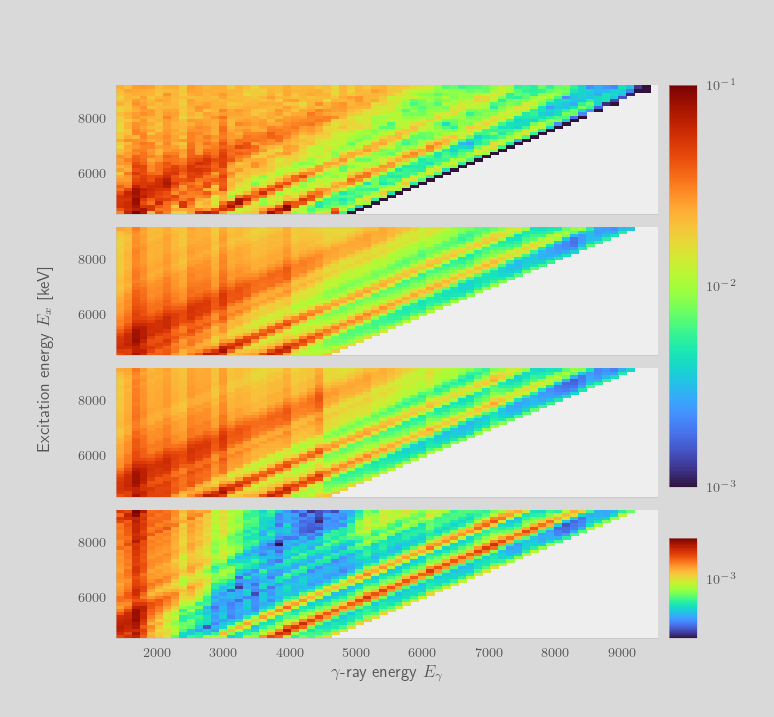

[0.001]
(0.0002004793951968228, 0.00318551873134054)


In [57]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots(4,1, sharex=True, sharey=True,
                          figsize=(2*fig_size[0], 3*fig_size[1]), constrained_layout=True)
    #fig.subplots_adjust(hspace=0.1)
    
    Ex, Eg = mat.Ex, mat.Eg
    mat.normalize('Ex')
    mesh, *_ = mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1, add_cbar=False)
    product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1, add_cbar=False)
    product_u.plot(ax=ax[2], scale="log", vmin=1e-3, vmax=1e-1, add_cbar=False)
    std_mesh, *_ = std.plot(ax=ax[3], scale='log', add_cbar=False, title=None)
    ax[0].set_ylabel(None)
    ax[1].set_ylabel(None)
    ax[2].set_ylabel(None)
    ax[3].set_ylabel(None)
    ax[0].set_xlabel(None)
    ax[1].set_xlabel(None)
    ax[2].set_xlabel(None)
    ax[0].set_title(None)
    fig.text(0.05, 0.5, r'Excitation energy $E_{x}$ [keV]', va='center', rotation='vertical')
    fig.colorbar(mesh, ax=ax[:3], aspect=30, fraction=0.046, pad=0.04)
    cbar = fig.colorbar(std_mesh, ax=ax[3], fraction=0.046, pad=0.046)
    print(cbar.ax.get_yticks())
    print(cbar.ax.get_ylim())
    fig.subplots_adjust(left=0.15, right=0.85, hspace=0.1)
    

    #x = np.linspace(*ax[0].get_ylim())
    #ax[0].plot(x, x, "r--", label="E_x = E_g")
    #ax[1].plot(x, x, "r--", label="E_x = E_g")
    savefig(fig, "products.pdf", dpi=300)

<IPython.core.display.Javascript object>


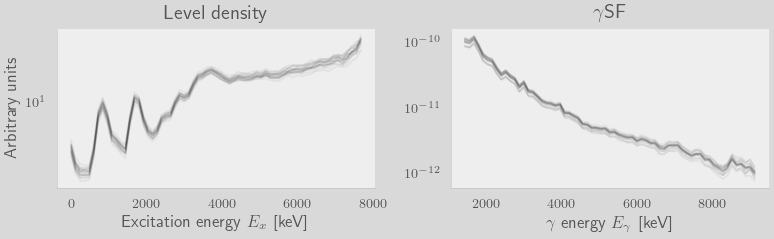

In [52]:
extractor = om.Extractor(path="./saved_run/extraction_ensemble/")
with plt.style.context("rapport"):
    fig, ax = plt.subplots(1,2, constrained_layout=True,
                          figsize=(2*fig_size[0], fig_size[1]))
    extractor.plot(ax=ax)
    savefig(fig, "unormalized.pdf", dpi=300)

<IPython.core.display.Javascript object>


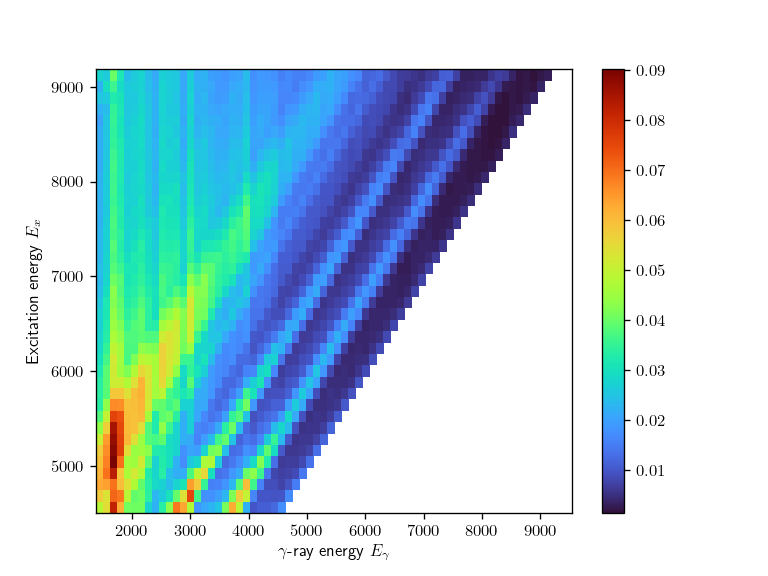

(<matplotlib.collections.QuadMesh at 0x7f3f9c7c4f40>,
 <Figure size 640x480 with 2 Axes>)

In [53]:
v = extractor.get_product(1, mat.Ex)
v.plot()

# Normalization

In [9]:
nldnorm = om.NormalizerNLD(path="normalization")
nldnorm.load()

<IPython.core.display.Javascript object>


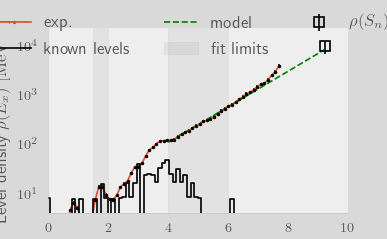

0.1297655296415412


In [10]:
with plt.style.context("rapport"):
    fig, ax = plt.subplots()
    #kshell.plot(ax=ax, kind='step', scale='log', label='KSHELL')
    nldnorm.plot(ax=ax)
    ax.set_xlim([0, 10])

## gSF

E1 giant dipole resonance data from EXFOR

In [11]:
def cross_section_to_MeV(cs, Eg):
    return 8.674e-8*cs/Eg

exfor = json.load(Path("normalization/exfor.json").open())
data = exfor["datasets"][0]['data']
Y, Yerr, X, _ = [np.asarray(x) for x in zip(*data)]
rel_err = Yerr/Y
Y = cross_section_to_MeV(Y, X)
Yerr = rel_err*Y
exfor = om.Vector(E=X, values=Y, std=Yerr, units='MeV')
exfor.save("matrices/exfor.npy")

E1 Calculations through QRPA on top of Hartree-Fock-Bogoliubov

In [12]:
qrpa = np.loadtxt("normalization/Zn-70-E1-HFB-QRPA.txt", skiprows=2)
qrpa[:, 1] *= 8.6737e-8
qrpa = om.Vector(E=qrpa[:, 0], values=qrpa[:, 1])
qrpa.save("matrices/qrpa.npy")

M1 strength function from KSHELL

In [13]:
gsf_M1 = om.Vector(path="matrices/gsf_sm.npy")
gsf_M1.E /= 1e3
gsf_M1.save("matrices/gsf_M1.npy")

In [14]:
summed = qrpa.forcefully_add(gsf_M1)

1.204200373366532


In [15]:
gsfnorm = om.NormalizerGSF(path="normalization/")
gsfnorm.load()

<IPython.core.display.Javascript object>


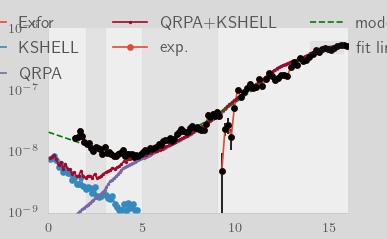

In [16]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots()
    exfor.plot(ax=ax, label='Exfor')
    gsf_M1.plot(ax=ax, label='KSHELL')
    qrpa.plot(ax=ax, label='QRPA', markersize=1)
    summed.plot(ax=ax, label='QRPA+KSHELL', markersize=1)
    gsfnorm.normalize()
    gsfnorm.plot(ax=ax, extrap_high=12)
    ax.set_yscale('log')
    ax.set_xlim([0, 16])
    ax.set_ylim([1e-9, 1e-6])

<IPython.core.display.Javascript object>


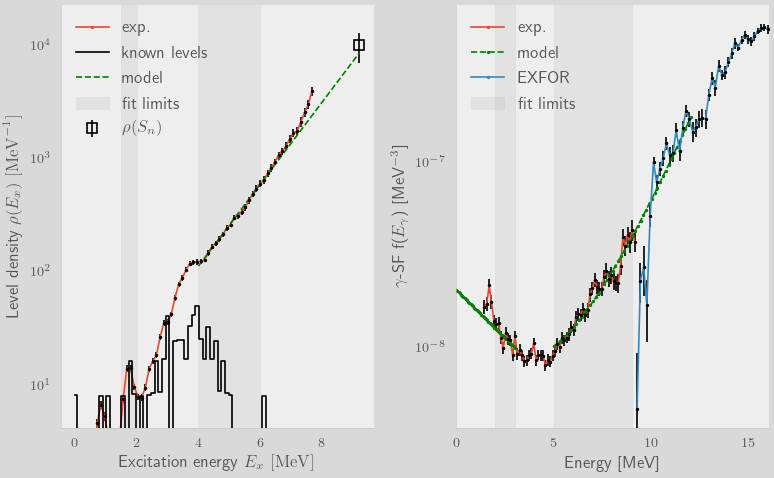

0.1297655296415412


In [18]:
with plt.style.context('rapport'):
    fig, (nld, gsf) = plt.subplots(ncols=2, figsize=2*fig_size,
                                  constrained_layout=True)
    nldnorm.plot(ax=nld, add_figlegend=False)
    gsfnorm.plot(ax=gsf, extrap_high=12, add_figlegend=False, markersize=1)
    exfor.plot(ax=gsf, markersize=1, label='EXFOR')
    gsf.set_yscale('log')
    gsf.set_xlim([0, 16])
    gsf.legend(loc=2, ncol=1)
    nld.legend(loc=2, ncol=1)
    savefig(fig, "normalized.pdf", dpi=300)

With KSHELL and QRPA

In [24]:
bin_width = 0.120
Ex_max = 12.5
inputfile = "kshell/summary_100.txt"
analyzer = Analyzer(inputfile, bin_width=bin_width, Ex_max=Ex_max)

Nbins=104
self.Ex_max=12.48


In [25]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(nrows=2, sharex=True,
                          figsize=(2*fig_size[0], 2*fig_size[1]))
    analyzer.plot_nld(ax=ax, cmap='turbo')  
    ax[0].set_xlim([0, 11])
    savefig(fig, 'nld_kshell.pdf', dpi=300)

<IPython.core.display.Javascript object>

In [26]:
E, nld = analyzer.total_nld()
nld_kshell = om.Vector(E=E[:-1], values=nld, units='MeV')

In [27]:
gsf_kshell = om.Vector(path='matrices/gsf_sm.npy')

In [28]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(constrained_layout=True)
    gsf_M1.plot(ax=ax, scale='log', markersize=1)
    ax.set_xlim([0, 7])
    ax.set_xlabel(r'$E_{\gamma}$ [MeV]')
    ax.set_ylabel(r'$\gamma$-SF f($E_\gamma$)~[MeV$^{{-3}}$]')
    savefig(fig, 'gsf_kshell.pdf', dpi=300)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


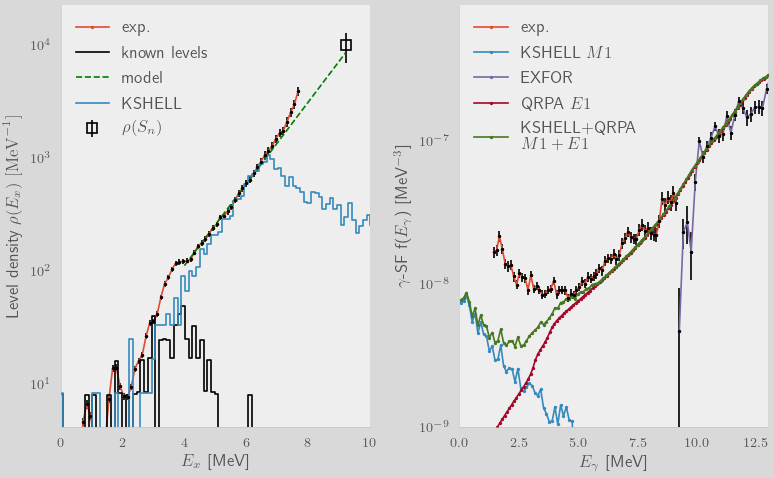

0.1297655296415412


In [33]:
with plt.style.context('rapport'):
    fig, (nld, gsf) = plt.subplots(ncols=2, figsize=2*fig_size,
                                  constrained_layout=True)
    nldnorm.plot(ax=nld, add_figlegend=False, plot_fitregion=False)
    gsfnorm.plot(ax=gsf, extrap_high=12, add_figlegend=False, markersize=1,
                plot_fitregion=False, plot_model=False)
    nld_kshell.plot(ax=nld, kind='step', label='KSHELL')
    gsf_M1.plot(ax=gsf, label='KSHELL $M1$', markersize=1)
    exfor.plot(ax=gsf, markersize=1, label='EXFOR')
    qrpa.plot(ax=gsf, label='QRPA $E1$', markersize=1)
    summed.plot(ax=gsf, label='KSHELL+QRPA\n $M1+E1$', markersize=1)
    nld.set_yscale('log')
    gsf.set_yscale('log')
    gsf.set_xlim([0, 13])
    nld.set_xlabel(r'$E_x$ [MeV]')
    gsf.set_xlabel(r'$E_{\gamma}$ [MeV]')
    gsf.legend(loc=2, ncol=1)
    nld.legend(loc=2, ncol=1)
    gsf.set_ylim([1e-9, 9e-7])
    nld.set_xlim([0, 10])
    savefig(fig, "normalized_model.pdf", dpi=300)

<IPython.core.display.Javascript object>


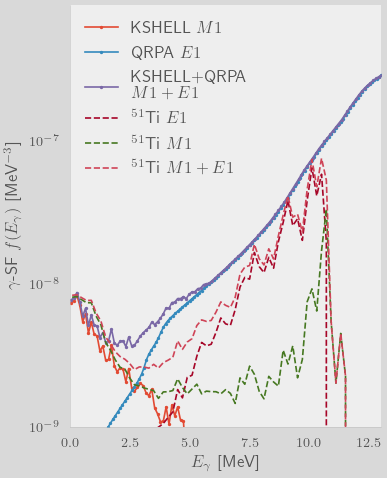

In [38]:
with plt.style.context('rapport'):
    fig, gsf = plt.subplots(ncols=1, figsize=(fig_size[0], 2*fig_size[1]),
                                  constrained_layout=True)
    #gsfnorm.plot(ax=gsf, extrap_high=12, add_figlegend=False, markersize=1,
    #            plot_fitregion=False, plot_model=False)
    gsf_M1.plot(ax=gsf, label='KSHELL $M1$', markersize=1)
    #exfor.plot(ax=gsf, markersize=1, label='EXFOR')
    qrpa.plot(ax=gsf, label='QRPA $E1$', markersize=1)
    summed.plot(ax=gsf, label='KSHELL+QRPA\n $M1+E1$', markersize=1)
    Ti51_E1.plot(ax=gsf, markersize=0, label='$^{51}$Ti $E1$', linestyle='--')
    Ti51_M1.plot(ax=gsf, markersize=0, label='$^{51}$Ti $M1$', linestyle='--')
    (Ti51_E1 + Ti51_M1).plot(ax=gsf, markersize=0, label='$^{51}$Ti $M1+E1$', linestyle='--')
    gsf.set_ylabel(r"$\gamma$-SF $f(E_\gamma)$ [MeV$^{-3}$]")
    gsf.set_yscale('log')
    gsf.set_xlim([0, 13])
    gsf.set_xlabel(r'$E_{\gamma}$ [MeV]')
    gsf.legend(loc=2, ncol=1)
    gsf.set_ylim([1e-9, 9e-7])
    savefig(fig, "normalized_model_models.pdf", dpi=300)

In [30]:
Ti51_E1 = np.loadtxt("normalization/Ti51-0_20_MeV-gsf-allspins-E1.txt")
Ti51_E1 = om.Vector(E=Ti51_E1[:, 0], values=Ti51_E1[:, 1])
Ti51_M1 = np.loadtxt("normalization/Ti51-0_20_MeV-gsf-allspins-M1.txt")
Ti51_M1 = om.Vector(E=Ti51_M1[:, 0], values=Ti51_M1[:, 1])

<IPython.core.display.Javascript object>


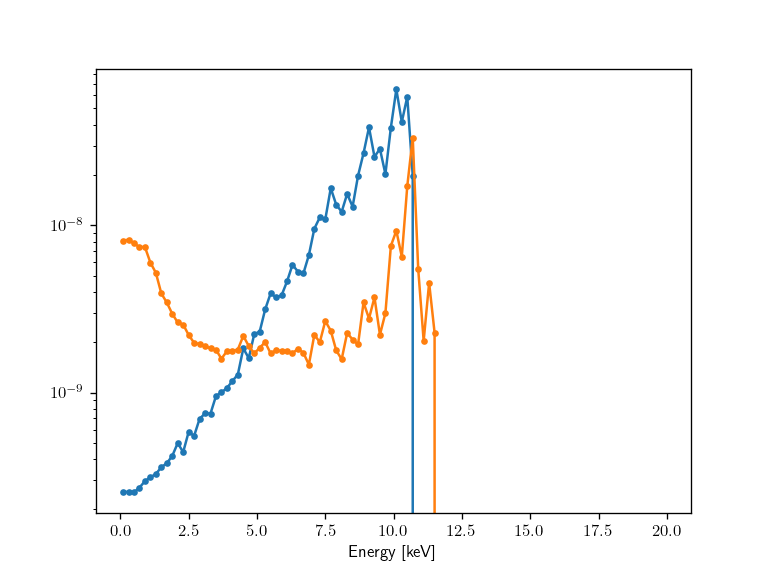

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac2cad7dc0>)

In [31]:
_, ax = Ti51_E1.plot()
Ti51_M1.plot(ax=ax, scale='log')

# Alignment

<IPython.core.display.Javascript object>


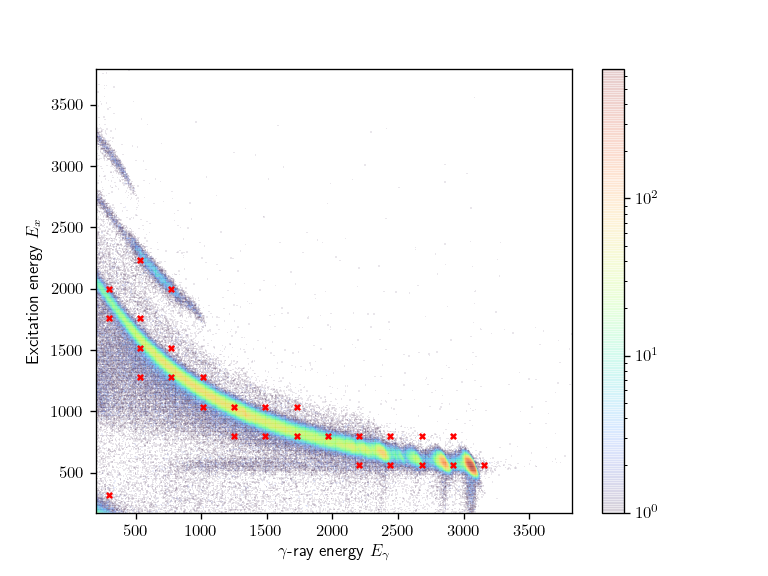

In [268]:
reference = om.Matrix(path="matrices/reference_mat.npy")
rex, rey = np.load('matrices/rex.npy'), np.load('matrices/rey.npy')
_, ax, fig = reference.plot(alpha=0.1)
ax.scatter(rex, rey, marker='x', s=10, color='r')

<IPython.core.display.Javascript object>


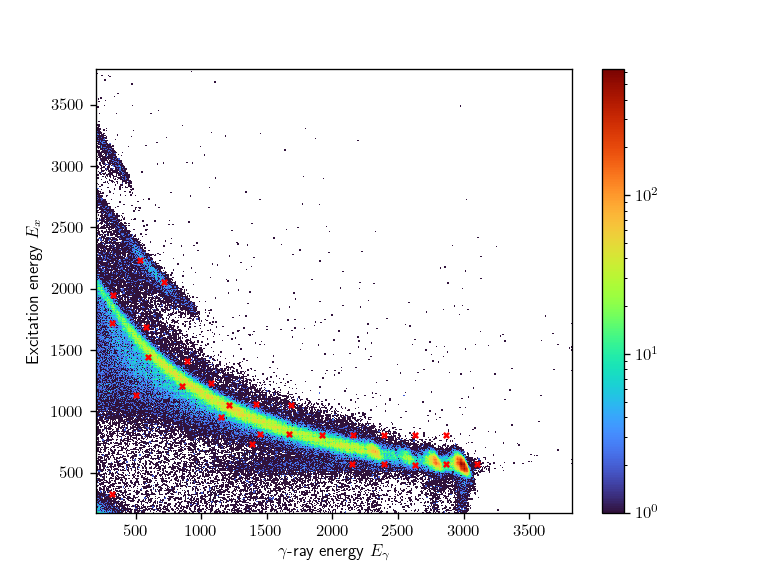

In [297]:
target = om.Matrix(path="matrices/target_mat.npy")
target_red = om.Matrix(path="matrices/target_red.npy")
tex, tey = np.load('matrices/tex.npy'), np.load('matrices/tey.npy')
weights = np.load('matrices/weights.npy')
_, ax, fig = target.plot()
ax.scatter(tex, tey, marker='x', s=10, color='r')

<IPython.core.display.Javascript object>


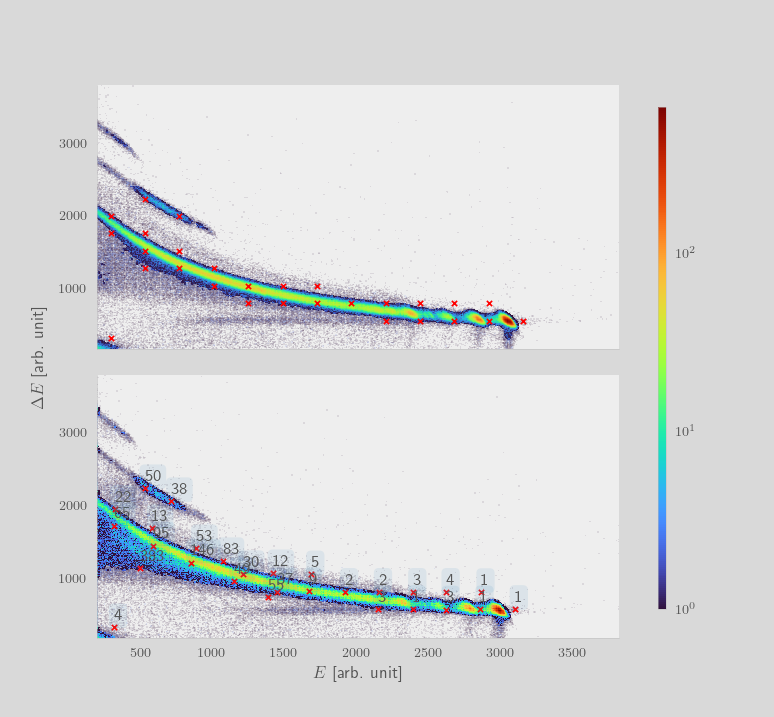

In [307]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(2, sharex=True, sharey=True,
                          figsize=(2*fig_size[0], 3*fig_size[1]),
                          constrained_layout=False)
    reduced = om.Matrix(path="matrices/reference_red.npy")
    mesh, _, _ = reduced.plot(ax=ax[0], add_cbar=False, rasterized=True)
    reference.plot(ax=ax[0], alpha=0.1, add_cbar=False, rasterized=True)
    ax[0].scatter(rex, rey, marker='x', s=10, color='r')
    ax[0].set_xlabel(None)
    ax[0].set_ylabel(None)
    target.plot(ax=ax[1], add_cbar=False, rasterized=True, alpha=0.1)
    target_red.plot(ax=ax[1], add_cbar=False, rasterized=True)
    for x, y, w in zip(tex, tey, weights):
        ax[1].annotate(f'{w:2.0f}', (x, 100+y),
                      bbox=dict(boxstyle='round', alpha=0.1))
    ax[1].scatter(tex, tey, marker='x', s=10, color='r')
    ax[1].set_ylabel(None)
    ax[1].set_xlabel("$E$ [arb. unit]")
    fig.text(0.04, 0.5, '$\Delta E$ [arb. unit]', va='center', rotation='vertical')
    fig.subplots_adjust(right=0.8, hspace=0.1)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(mesh, cax=cbar_ax)
    savefig(fig, "siri_plot.pdf", dpi=300)

In [4]:
gauss = np.random.multivariate_normal([1, 1], [[1.2, 0], [0, 1.1]], 1000000)
gauss_2 = np.random.multivariate_normal([2, 0.5], [[1, 0], [0, 1]], 2000000)


<IPython.core.display.Javascript object>


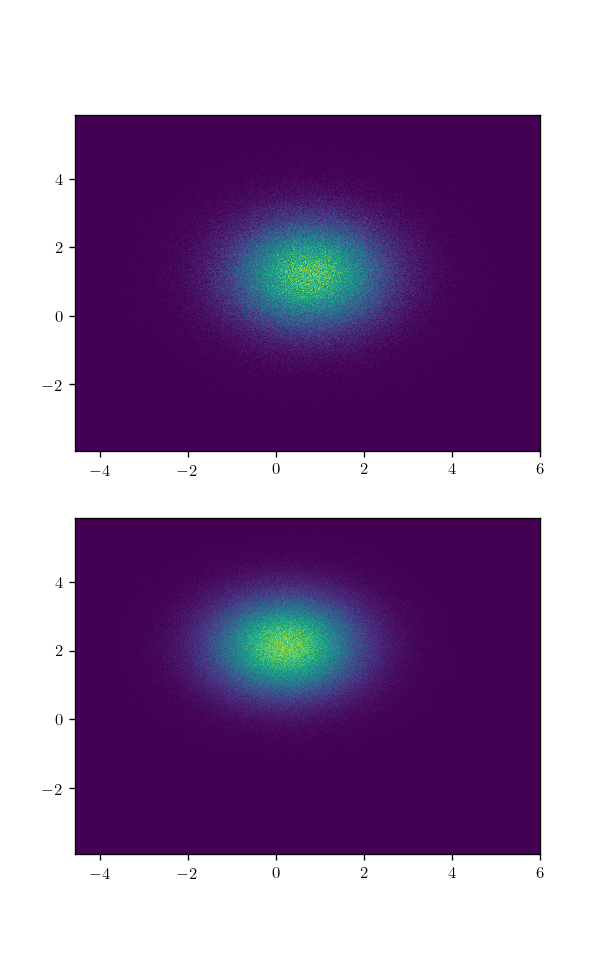

In [158]:
mat, x, y = np.histogram2d(gauss[:, 0], gauss[:, 1], 500)
mat_2, x_2, y_2 =np.histogram2d(gauss_2[:, 0], gauss_2[:, 1], (x, y))
#fig, ax = plt.subplots(figsize=(5, 5))
#ax.scatter(gauss[:, 0], gauss[:, 1], alpha=0.5)
#ax.scatter(gauss_2[:, 0], gauss_2[:, 1], alpha=0.5)

fig, ax = plt.subplots(2, figsize=(5, 8))
ax[0].pcolormesh(x, y, mat)
ax[1].pcolormesh(x_2, y_2, mat_2)

<IPython.core.display.Javascript object>


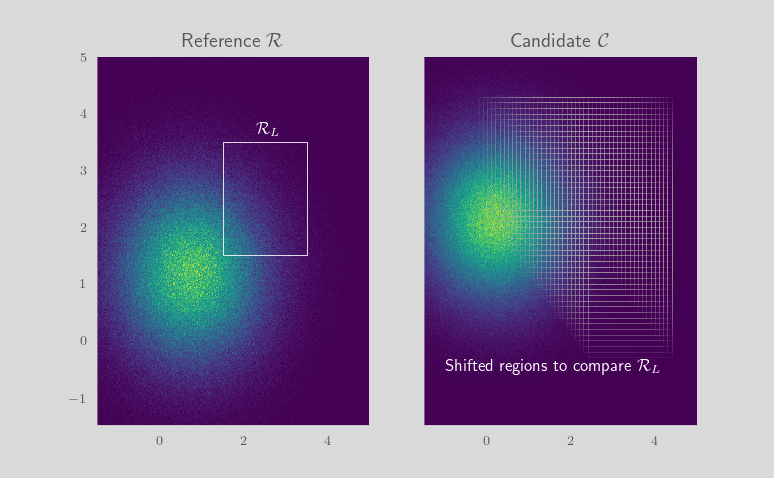

In [248]:
with plt.style.context('rapport'):
    fig, ax = plt.subplots(ncols=2, figsize=2*fig_size,
                          sharex=True, sharey=True)
    ax[0].pcolormesh(x, y, mat, rasterized=True)
    ax[1].pcolormesh(x_2, y_2, mat_2, rasterized=True)
    X, Y = 1.5, 1.5
    Xw, Yw = 2, 2
    ax[0].add_collection(PatchCollection([Rectangle((X, Y), Xw, Yw)], 
                                         edgecolor='w',
                                         facecolor='none', alpha=1))
    patches = []
    for _x in np.arange(-1, 2.5, 0.1):
        for _y in np.arange(2.3, -1, -0.1):
            if _x + _y < 2:
                continue
            patches.append(Rectangle((_x, _y), 2, 2))
    ax[1].add_collection(PatchCollection(patches, 
                                         edgecolor='#b3b3b3',
                                         facecolor='none', alpha=0.1))
            
    ax[0].set_title('Reference $\mathcal{R}$')
    ax[1].set_title('Candidate $\mathcal{C}$')
    ax[1].set_xlim([-1.5, 5])
    ax[1].set_ylim([-1.5, 5])
    ax[0].annotate('$\mathcal{R}_L$', xy=(2.3, 3.6), color='w')
    ax[1].annotate('Shifted regions to compare $\mathcal{R}_L$', xy=(-1, -.6), color='w')
    savefig(fig, "matrices.pdf", dpi=196)

In [125]:
np.save("matrices/gauss_1.npy", mat)
np.save("matrices/gauss_2.npy", mat_2)

In [38]:
topo = np.load("matrices/topo.npy")
topo = topo / topo.sum()

<IPython.core.display.Javascript object>


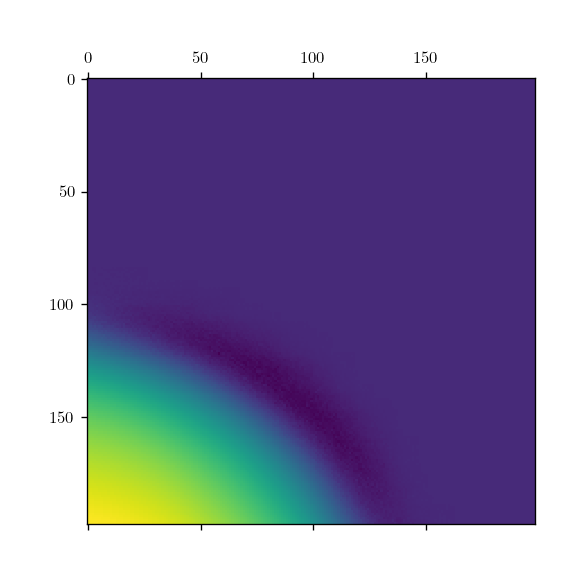

In [39]:
plt.matshow(topo, norm=LogNorm())

In [75]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

<IPython.core.display.Javascript object>


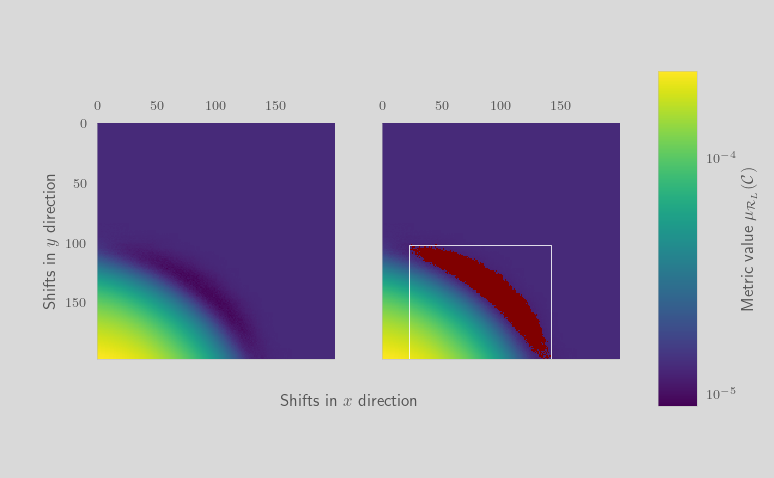

In [151]:
with plt.style.context("rapport"):
    fig, (fax, ax) = plt.subplots(ncols=2, sharey=True, sharex=True,
                                 figsize=(2*fig_size[0], 2*fig_size[1]))
    fax.matshow(topo, norm=LogNorm())
    mesh= ax.matshow(topo, norm=LogNorm())
   
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(mesh, cax=cax) 
    cax.set_ylabel("Metric value $\mu_{\mathcal{R}_L}(\mathcal{C})$")
    fig.text(0.45, 0.15, 'Shifts in $x$ direction', ha='center') 
    fax.set_ylabel('Shifts in $y$ direction')
    #masked = np.ma.masked_where(topo > 1.2e-5, 10+np.zeros_like(topo))
    masked = topo.copy()
    masked[topo < 1.2e-5] = 1
    masked[topo > 1.2e-5] = np.nan

    cmap = ListedColormap([[128/255, 0.0, 0.0], 'w', 'r'])
    ax.matshow(masked, cmap=cmap)
    ax.add_collection(PatchCollection([Rectangle((22, 102), 119, 95)], edgecolor='w',
                                     facecolor='none', alpha=1))
    savefig(fig, 'topology.pdf', dpi=300)

In [ ]:
def thresholdarea(x):
    
    for x in range(x.shape[0]):
        for y in range(y.shape[1]):
            
function (w::ThresholdArea)(x)
    min = minimum(x)
    thresholded = x .≤ w.threshold*min
    maxx = maxy = -1
    miny = minx = 1e5
    for x in 1:size(thresholded, 1), y in 1:size(thresholded, 2)
        if thresholded[x, y]
            if x < minx
                minx = x
            end
            if x > maxx
                maxx = x
            end
            if y < miny
                miny = y
            end
            if y > maxy
                maxy = y
            end
        end
    end
    sidex = maxx - minx
    sidey = maxy - miny
    (sidex > 0 ? sidex : 1) * (sidey > 0 ? sidey : 1)
end

In [55]:
masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)